In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2022-04-12 01:48:04--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.124
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  13.4MB/s    in 36s     

2022-04-12 01:48:41 (8.80 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.backend import int_shape

In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

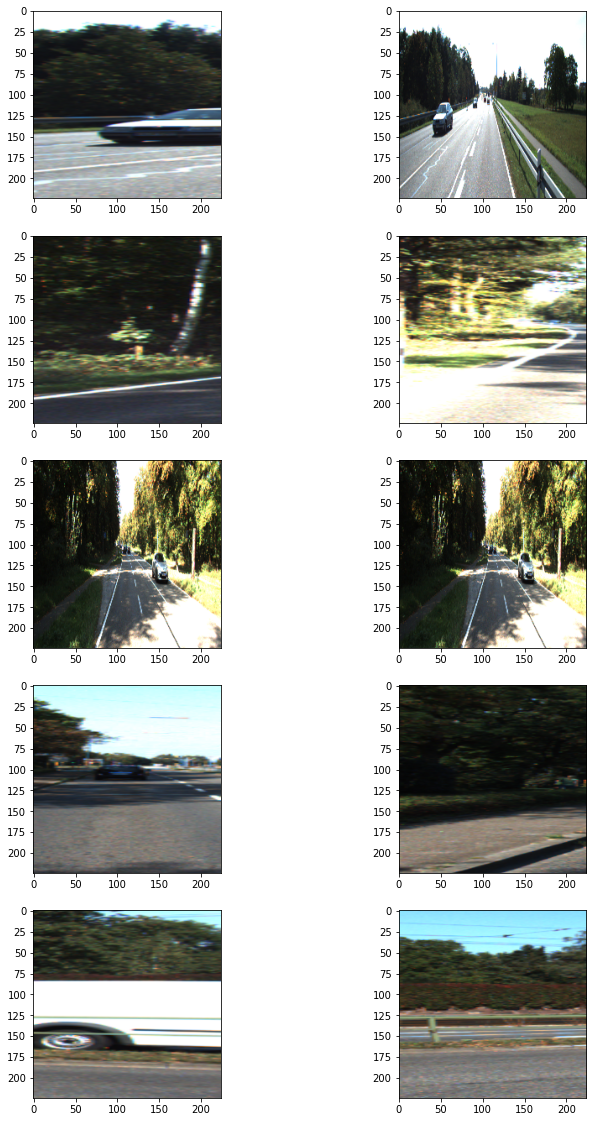

In [6]:
import os

dir_path = '/content/drive/MyDrive/Colab Notebooks/data_semantics/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [7]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [8]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [9]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [10]:
def Unet_model(input_shape=(224, 224, 3), filters= [64, 128, 256, 512, 1024], kernel=3):
    inputs = Input(input_shape)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    b1 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(b1)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    b2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(b2)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    b3 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(b3)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    b4 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(b4)
    x = Dropout(0.5)(x)
    x = Conv2D(filters[4], kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u1_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b4), int_shape(x))
    r1 = Cropping2D(cropping=(ch, cw), name='u1_resize')(b4)
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b3), int_shape(x))
    r2 = Cropping2D(cropping=(ch, cw), name='u2_resize')(b3)
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='valid', name='u3_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b2), int_shape(x))
    r3 = Cropping2D(cropping=(ch, cw), name='u3_resize')(b2)
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='valid', name='u4_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b1), int_shape(x))
    r4 = Cropping2D(cropping=(ch, cw ), name='u4_resize')(b1)
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [11]:
u_model = Unet_model()
u_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 b1_conv1 (Conv2D)              (None, 222, 222, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 b1_conv2 (Conv2D)              (None, 220, 220, 64  36928       ['b1_conv1[0][0]']               
                                )                                                             

In [12]:
u_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
history = u_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
u_model.save(model_path)  #학습한 모델을 저장해 주세요.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
43/43 [==============================] - 49s 744ms/step - loss: 0.6362 - val_loss: 0.5118
Epoch 2/100
43/43 [==============================] - 5s 108ms/step - loss: 0.1722 - val_loss: 0.1445
Epoch 3/100
43/43 [==============================] - 5s 109ms/step - loss: 0.1352 - val_loss: 0.1204
Epoch 4/100
43/43 [==============================] - 5s 109ms/step - loss: 0.1290 - val_loss: 0.1139
Epoch 5/100
43/43 [==============================] - 5s 109ms/step - loss: 0.1146 - val_loss: 0.1223
Epoch 6/100
43/43 [==============================] - 5s 109ms/step - loss: 0.1269 - val_loss: 0.1253
Epoch 7/100
43/43 [==============================] - 5s 115ms/step - loss: 0.1168 - val_loss: 0.1302
Epoch 8/100
43/43 [==============================] - 5s 110ms/step - loss: 0.1148 - val_loss: 0.0973
Epoch 9/100
43/43 [==============================] - 5s 108ms/step - loss: 0.0917 - val_loss: 0.0943
Epoch 10/100
43/43 [==============================] - 5s 108ms/step - loss: 0.0936 - val_l

In [13]:
def Upp_model(input_shape=(224, 224, 3), filters= [0, 64, 128, 256, 512], kernel=3):
    inputs = Input(input_shape)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
#     x0_0 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x0_0)
    
    x1_0 = MaxPooling2D(pool_size=(2,2), name='x1_0_pool')(inputs)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv1')(inputs)
    x1_0 = BatchNormalization()(x1_0)
    x1_0 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_0_conv2')(x1_0)
    x1_0 = BatchNormalization()(x1_0)
    
    x2_0 = MaxPooling2D(pool_size=(2,2), name='x2_0_pool')(x1_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv1')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    x2_0 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_0_conv2')(x2_0)
    x2_0 = BatchNormalization()(x2_0)
    
    x3_0 = MaxPooling2D(pool_size=(2,2), name='x3_0_pool')(x2_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv1')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    x3_0 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_0_conv2')(x3_0)
    x3_0 = BatchNormalization()(x3_0)
    
    x4_0 = MaxPooling2D(pool_size=(2,2), name='x4_0_pool')(x3_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv1')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    x4_0 = Conv2D(filters[4], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x4_0_conv2')(x4_0)
    x4_0 = BatchNormalization()(x4_0)
    
    u4_0 = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u4_0_convTran')(x4_0)
    r3_0 = tf.image.resize(x3_0, (u4_0.shape[1], u4_0.shape[2]), name='x3_0_resize')
    x3_1 = concatenate([r3_0, u4_0], axis = 3, name='x3_1_merge')
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv1')(x3_1)
    x3_1 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x3_1_conv2')(x3_1)
    
    # 2-2로 감
    u3_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_0_convTran')(x3_0)
    r2_0 = tf.image.resize(x2_0, (u3_0.shape[1], u3_0.shape[2]), name='a_r2_0_resize')
    x2_1 = concatenate([r2_0,u3_0], axis = 3, name='x2_1_merge')
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv1')(x2_1)
    x2_1 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_1_conv2')(x2_1)
    
    # origin
    u3_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u3_1_convTran')(x3_1)
    r2_0 = tf.image.resize(x2_0, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_0_resize')
    r2_1 = tf.image.resize(x2_1, (u3_1.shape[1], u3_1.shape[2]), name='b_r2_1_resize')
    x2_2 = concatenate([r2_0,r2_1, u3_1], axis = 3, name='x2_2_merge')
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv1')(x2_2)
    x2_2 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x2_2_conv2')(x2_2)
    
    # 1-3로 감
    u2_0 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_0_convTran')(x2_0)
    r1_0 = tf.image.resize(x1_0, (u2_0.shape[1], u2_0.shape[2]), name='a_r1_0_resize')
    x1_1 = concatenate([r1_0,u2_0], axis = 3, name='x1_1_merge')
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv1')(x1_1)
    x1_1 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_1_conv2')(x1_1)
    
    # 1-3로 감
    u2_1 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_1_convTran')(x2_1)
    r1_0 = tf.image.resize(x1_0, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_1.shape[1], u2_1.shape[2]), name='b_r1_1_resize')
    x1_2 = concatenate([r1_0, r1_1, u2_1], axis = 3, name='x1_2_merge')
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv1')(x1_2)
    x1_2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_2_conv2')(x1_2)
    
    # origin
    u2_2 = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_2_convTran')(x2_2)
    r1_0 = tf.image.resize(x1_0, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_0_resize')
    r1_1 = tf.image.resize(x1_1, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_1_resize')
    r1_2 = tf.image.resize(x1_2, (u2_2.shape[1], u2_2.shape[2]), name='c_r1_2_resize')
    x1_3 = concatenate([r1_0, r1_1, r1_2, u2_2], axis = 3, name='x1_3_merge')
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv1')(x1_3)
    x1_3 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='x1_3_conv2')(x1_3)
    x1_3 = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='x1_3_conv3')(x1_3)
    x1_3 = Conv2D(1, 1, activation='sigmoid')(x1_3)
    output = tf.image.resize(x1_3, (inputs.shape[1], inputs.shape[2]), name='output')
    model = Model(inputs = inputs, outputs = output)
    return model

In [14]:
upp_model = Upp_model()
upp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 x1_0_conv1 (Conv2D)            (None, 222, 222, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 222, 222, 64  256        ['x1_0_conv1[0][0]']             
 alization)                     )                                                           

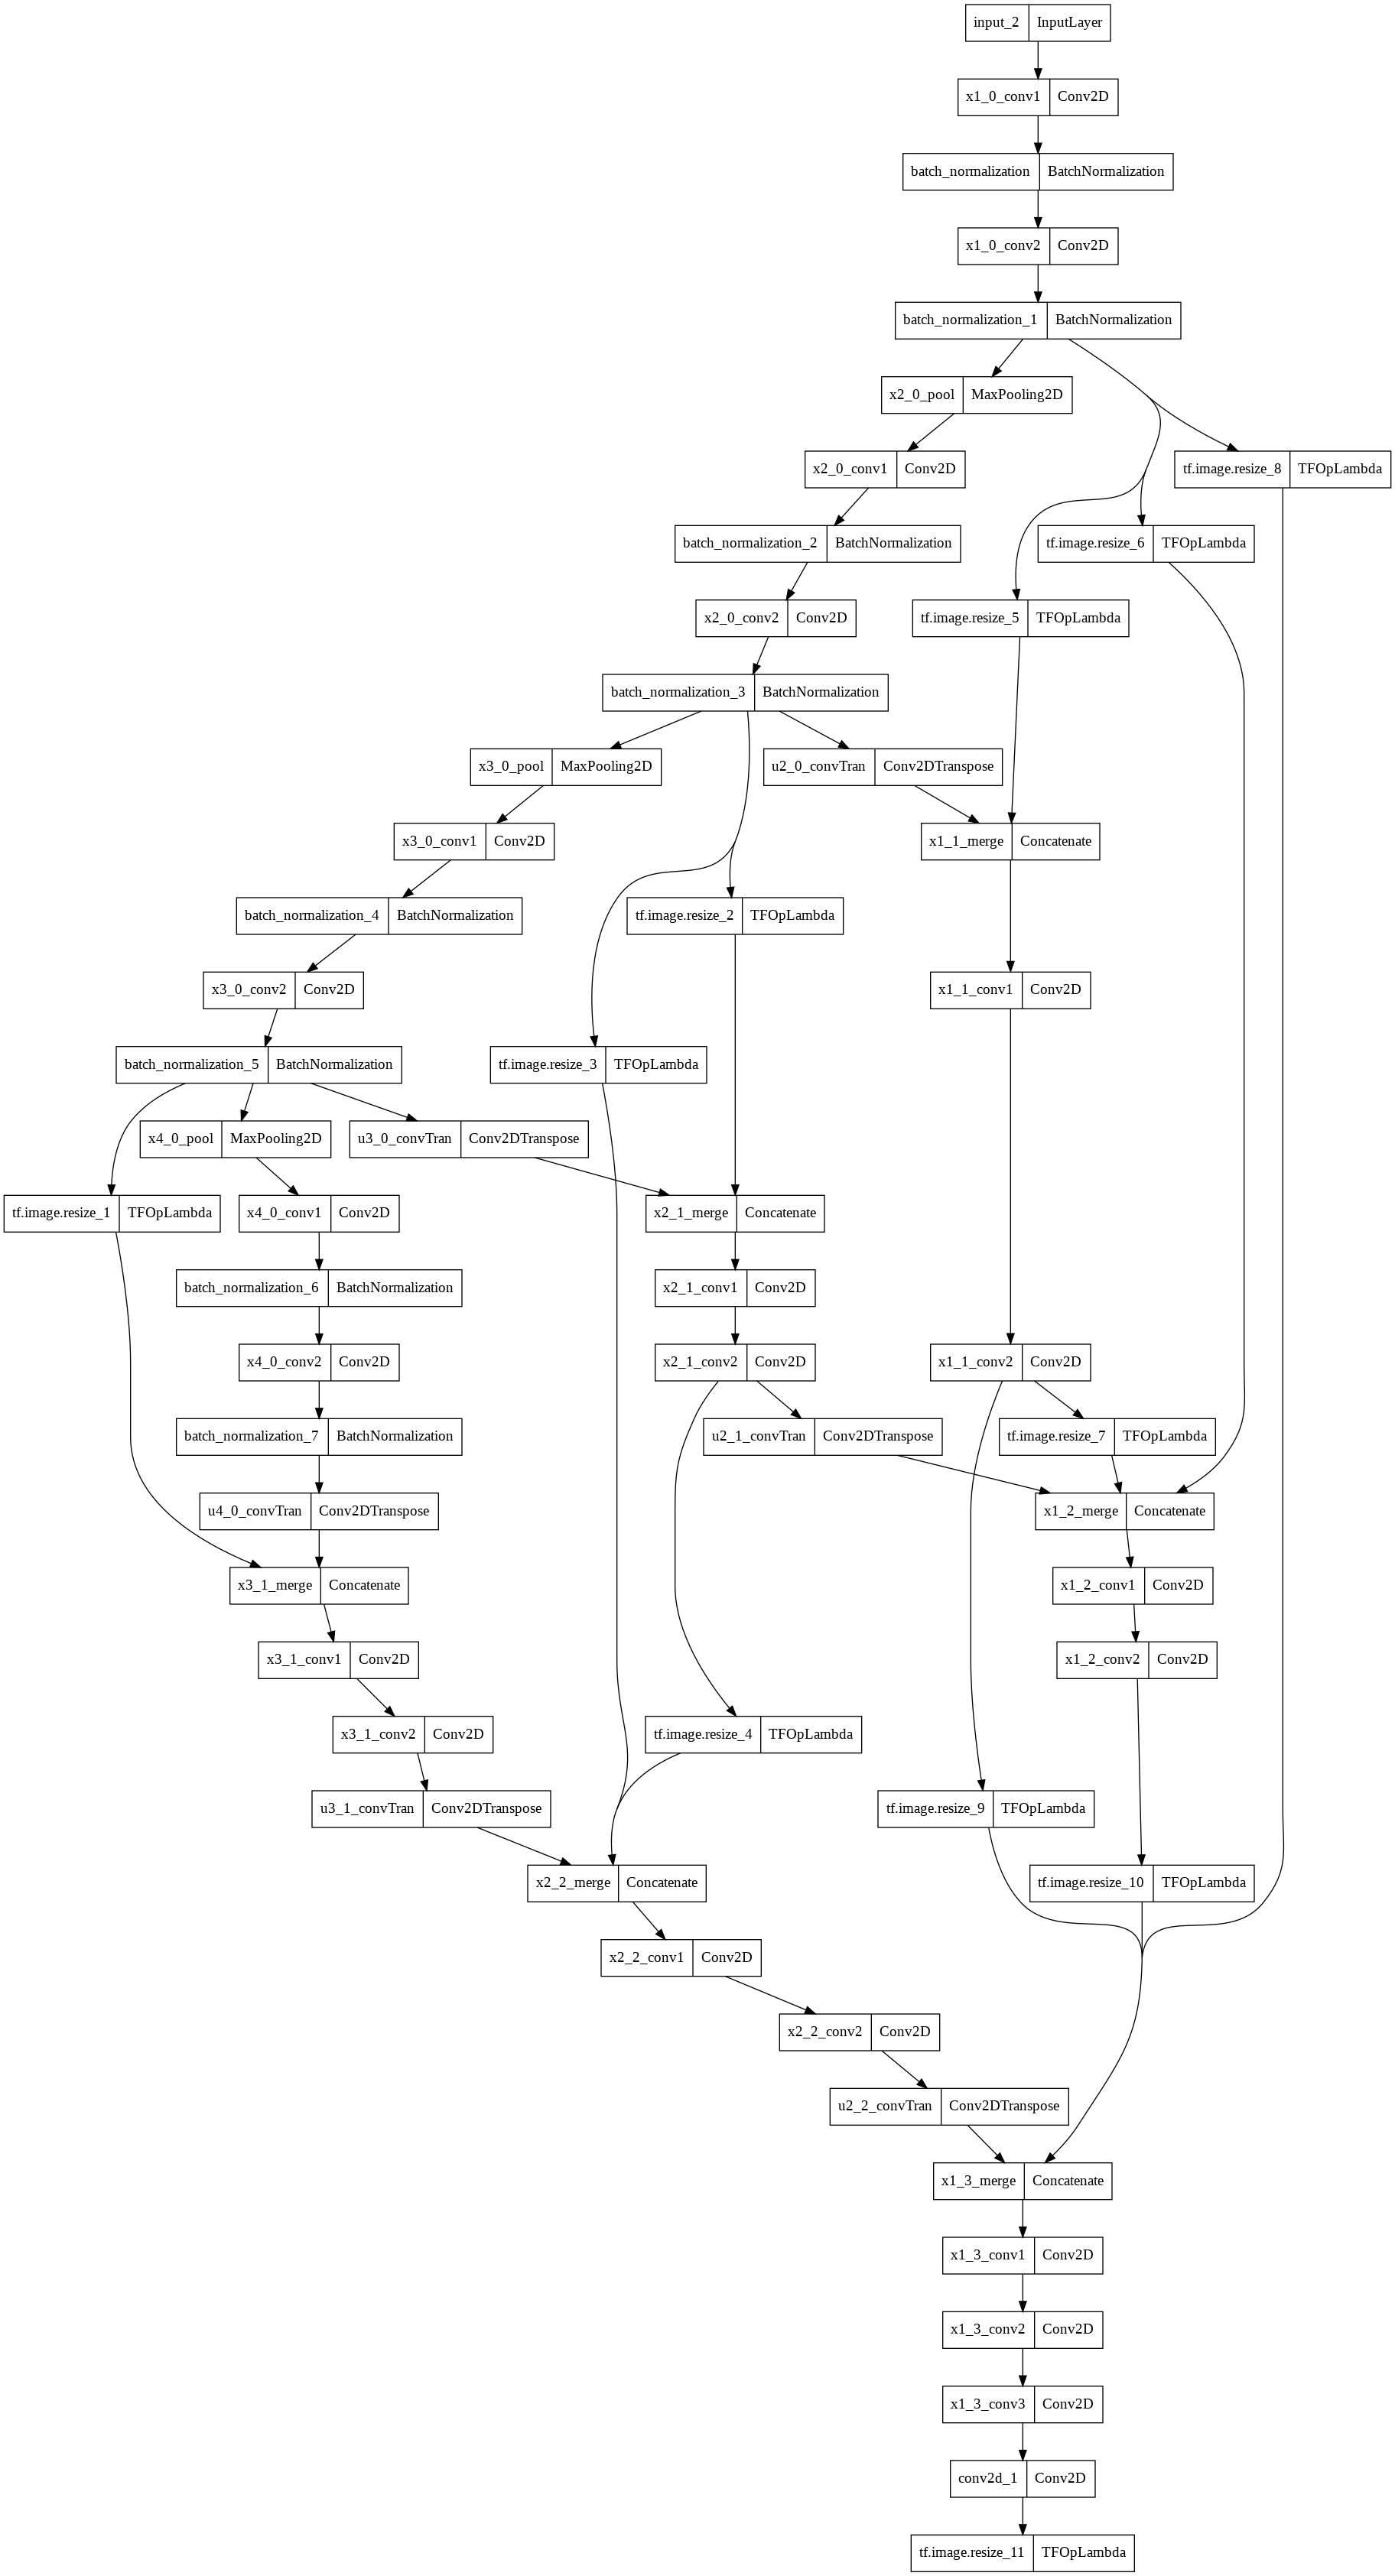

In [15]:
tf.keras.utils.plot_model(upp_model, to_file='./upp_model.png')

In [26]:
upp_model = Upp_model()
upp_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
upp_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_uppnet.h5'
upp_model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


43/43 [==============================] - 13s 247ms/step - loss: 0.1619 - val_loss: 0.1967
Epoch 2/100
43/43 [==============================] - 10s 240ms/step - loss: 0.0871 - val_loss: 0.1774
Epoch 3/100
43/43 [==============================] - 10s 240ms/step - loss: 0.0809 - val_loss: 0.1681
Epoch 4/100
43/43 [==============================] - 10s 243ms/step - loss: 0.0808 - val_loss: 0.1489
Epoch 5/100
43/43 [==============================] - 11s 244ms/step - loss: 0.0738 - val_loss: 0.1394
Epoch 6/100
43/43 [==============================] - 11s 246ms/step - loss: 0.0578 - val_loss: 0.1581
Epoch 7/100
43/43 [==============================] - 11s 248ms/step - loss: 0.0684 - val_loss: 0.1722
Epoch 8/100
43/43 [==============================] - 11s 249ms/step - loss: 0.0635 - val_loss: 0.1136
Epoch 9/100
43/43 [==============================] - 11s 250ms/step - loss: 0.0557 - val_loss: 0.1802
Epoch 10/100
43/43 [==============================] - 11s 251ms/step - loss: 0.0529 - val_loss

In [27]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)

In [28]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [29]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()  
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

UNet 에 대한 실험
channel = [64, 128, 256, 512]

In [30]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     u_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.427941


0.4279412944101371

channel = [64, 128, 256, 512, 1024], Upsampling 전 dropout 추가

In [31]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     u_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.743036


0.7430359004915835

U++ Net 에 대한 실험
Dropout 제거 & channel =2 Conv layer 미사용

In [32]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.516829


0.5168288403254108

In [33]:
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.516829


0.5168288403254108

In [34]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     upp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'/result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.890342


0.8903416889402587